# Neuro ML 2020

## Seminar 5: Functional connectivity

In [2]:
pip install nilearn

     |████████████████████████████████| 10.0 MB 10.2 MB/s 


In [3]:
pip install diagram2vec

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import nilearn # pip install nilearn
import networkx as nx # pip install networkx
import diagram2vec # pip install diagram2vec

## Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# load ABIDE1 data from NYU site
ts = np.load("/content/drive/My Drive/NeuroML/seminar5/data/TS_R_NYU.npy")
(n_patients, n_steps, n_regions) = ts.shape

In [8]:
n_patients, n_steps, n_regions

(172, 176, 116)

### Multivariate time-series

#### Visualization of time series

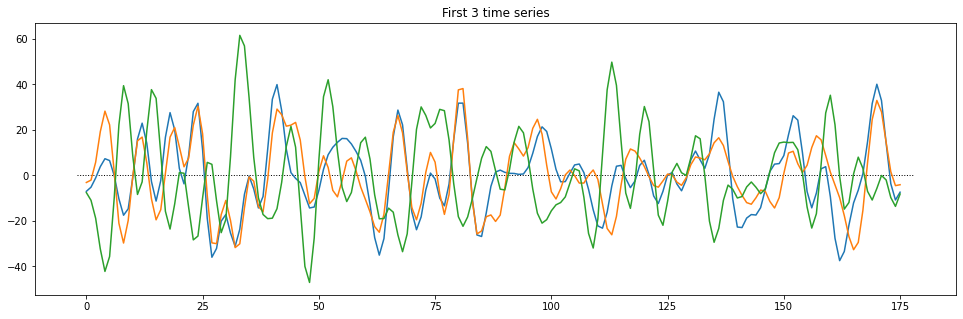

In [9]:
# visualization of raw time series
plt.figure(figsize=(16.5,5))
plt.title("First 3 time series")
plt.hlines(0, -2, n_steps+2, linewidth=1.0, linestyles="dotted")
plt.plot(ts[0,:,:3])
plt.show()

In [10]:
# mean and standard deviation
print("Mean ± std of the:")
print("1st time series: {:.3f} ± {:.3f}".format(np.mean(ts[0,:,0]), np.std(ts[0,:,0])))
print("2nd time series: {:.3f} ± {:.3f}".format(np.mean(ts[0,:,1]), np.std(ts[0,:,1])))
print("3rd time series: {:.3f} ± {:.3f}".format(np.mean(ts[0,:,2]), np.std(ts[0,:,2])))

Mean ± std of the:
1st time series: -0.000 ± 16.361
2nd time series: 0.000 ± 15.272
3rd time series: 0.000 ± 19.844


#### Normalization and trend removal

In [11]:
# break 2nd and 3rd time series
ts[0,:,1] = ts[0,:,1] + 150 # add mean shift
ts[0,:,2] = ts[0,:,2] + np.linspace(0, 150, n_steps) # add trend

In [12]:
print("Mean ± std of the:")
print("1st time series: {:.3f} ± {:.3f}".format(np.mean(ts[0,:,0]), np.std(ts[0,:,0])))
print("2nd time series: {:.3f} ± {:.3f}".format(np.mean(ts[0,:,1]), np.std(ts[0,:,1])))
print("3rd time series: {:.3f} ± {:.3f}".format(np.mean(ts[0,:,2]), np.std(ts[0,:,2])))

Mean ± std of the:
1st time series: -0.000 ± 16.361
2nd time series: 150.000 ± 15.272
3rd time series: 75.000 ± 47.856


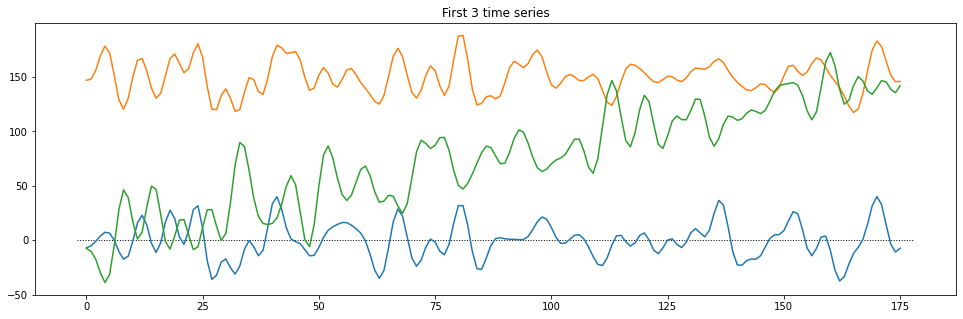

In [13]:
# visualization of broken time series
plt.figure(figsize=(16.5,5))
plt.title("First 3 time series")
plt.hlines(0, -2, n_steps+2, linewidth=1.0, linestyles="dotted")
plt.plot(ts[0,:,:3])
plt.show()

In [14]:
from nilearn.signal import clean

In [15]:
ts_normalized = np.zeros_like(ts)

# normalize and detrend
for i in range(ts.shape[0]):
    ts_normalized[i] = clean(ts[i], standardize="zscore", detrend=True)
    
print("Mean ± std of the:")
print("1st time series: {:.3f} ± {:.3f}".format(np.mean(ts_normalized[0,:,0]), np.std(ts_normalized[0,:,0])))
print("2nd time series: {:.3f} ± {:.3f}".format(np.mean(ts_normalized[0,:,1]), np.std(ts_normalized[0,:,1])))
print("3rd time series: {:.3f} ± {:.3f}".format(np.mean(ts_normalized[0,:,2]), np.std(ts_normalized[0,:,2])))

Mean ± std of the:
1st time series: -0.000 ± 1.000
2nd time series: -0.000 ± 1.000
3rd time series: 0.000 ± 1.000


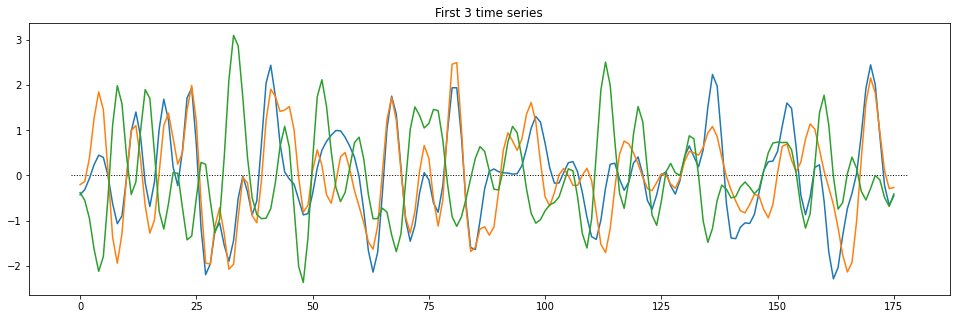

In [16]:
# visualization of raw time series
plt.figure(figsize=(16.5,5))
plt.title("First 3 time series")
plt.hlines(0, -2, n_steps+2, linewidth=1.0, linestyles="dotted")
plt.plot(ts_normalized[0,:,:3])
plt.show()

## Metrics of functional connectivity

### Pearson correlation

In [17]:
from nilearn.connectome import ConnectivityMeasure
from sklearn.covariance import EmpiricalCovariance

covariance_estimator = EmpiricalCovariance()
connectivity_correlation = ConnectivityMeasure(kind="correlation", cov_estimator=covariance_estimator)

In [18]:
ts[0].shape

(176, 116)

In [19]:
R = connectivity_correlation.fit_transform(ts)
R.shape

(172, 116, 116)

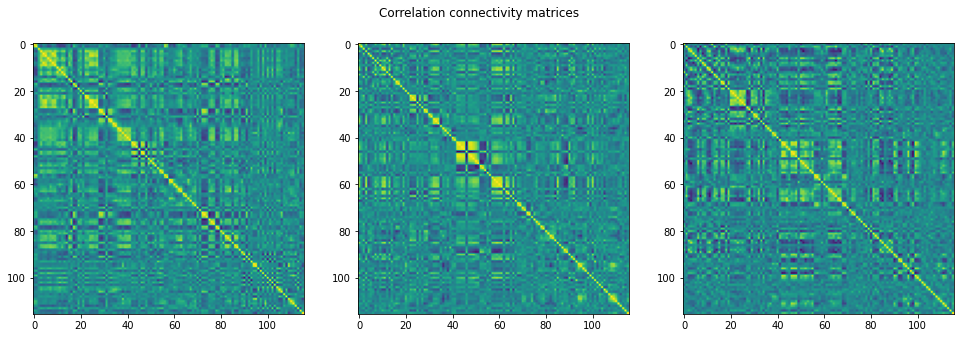

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16.5,5))
plt.suptitle("Correlation connectivity matrices")
ax1.imshow(R[0])
ax2.imshow(R[1])
ax3.imshow(R[2])
plt.show()

### Regularization

_Condition number_ - minimum/maximum eigenvalue ratio of a matrix


#### Tikhonov regularization

$$\tilde{\mathbf{C}}_X = \mathbf{C}_X + \alpha \mathbf{I},~~~\alpha > 0$$

**Task**

Check the minimum eigenvalue of a correlation matrix

In [21]:
np.min(np.linalg.eigvalsh(R[0]))

-1.9492407367423085e-16

**Task**

Apply Tikhonov regularization and check how it affects the minimum eigenvalue of a correlation matrix

In [22]:
### your code here

alpha = 0.01
R_regularized = R[0] + alpha * np.eye(n_regions)

#### Shrinkage estimators

Ledoit-Wolf

$$\tilde{\mathbf{C}}_X = (1 - \beta)\mathbf{C}_X + \alpha \beta \mathbf{I},~~~\alpha > 0, 0 \leq \beta \leq 1\\
\alpha = \frac{trace(\mathbf{C})}{n_{features}}$$

A well conditioned estimator for large dimensional covariance matrices, $\alpha$ is predefined according to formula, $\beta$ is inferred from data.

In [23]:
from sklearn.covariance import LedoitWolf

cov_estimator_shrinked = LedoitWolf()
connectivity_correlation_shrinked = ConnectivityMeasure(kind="correlation", cov_estimator=cov_estimator_shrinked)

In [24]:
# check the value of beta parameter
cov = cov_estimator_shrinked.fit(ts[0])
cov.shrinkage_

0.06909188386336448

In [25]:
R_shrinked = connectivity_correlation_shrinked.fit_transform(ts)

In [26]:
# checking the minimum eigenvalue
np.min(np.linalg.eigvalsh(R_shrinked[0]))

0.07647627343088059

### Spearman correlation

In [30]:
from scipy.stats import spearmanr

In [31]:
S = np.zeros((3, n_regions, n_regions))

for i in range(3):
    S[i], _ = spearmanr(ts[i])

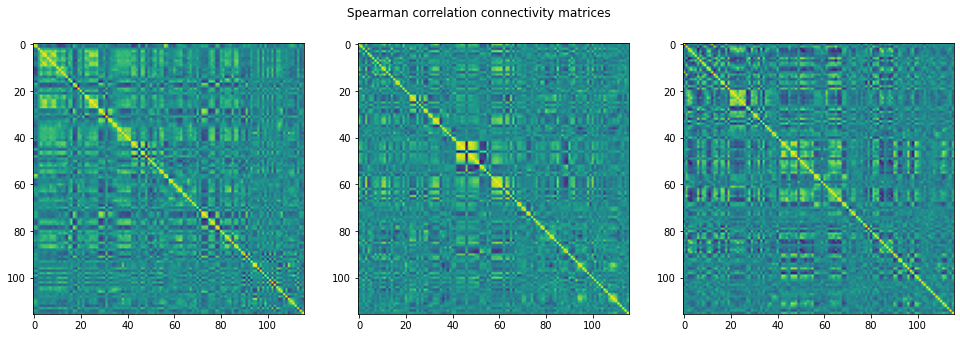

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16.5,5))
plt.suptitle("Spearman correlation connectivity matrices")
ax1.imshow(S[0])
ax2.imshow(S[1])
ax3.imshow(S[2])
plt.show()

### Mutual information

Mutual information measures the information that random variables $X$ and $Y$ share, how much knowing one of these variables reduces uncertainty about the other. determined how different to joint distributon $p(X, Y)$ is to the production of the marginal distrubutions $p(X) p(Y)$.

$$I(X, Y) = \sum_{(x, y)} p(x, y) \log_2 \left( \frac{p(x, y)}{p(x)p(y)} \right)$$

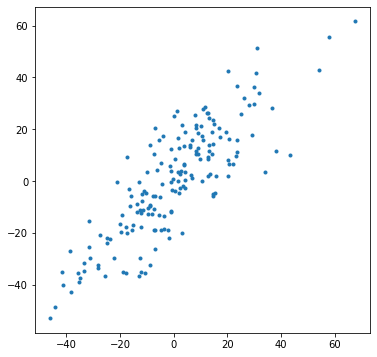

In [33]:
plt.figure(figsize=(6,6))
plt.plot(ts[2,:,0], ts[2,:,12], ".")

In [34]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins=10):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def bound(x):
    return np.sqrt(1 - np.exp(-2 * x))

In [35]:
l = calc_MI(ts[1,:,42], ts[1,:,45])
l, bound(l)

(0.7207063755681488, 0.8737314947691185)

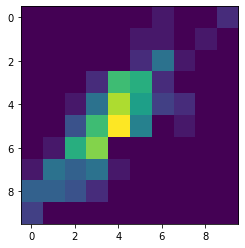

In [36]:
c_xy = np.rot90(np.histogram2d(ts[2,:,0], ts[2,:,12], 10)[0])
plt.imshow(c_xy)

In [37]:
l = calc_MI(ts[1,:,42], ts[1,:,41])
l, bound(l)

(0.2461990393406313, 0.6235711442795376)

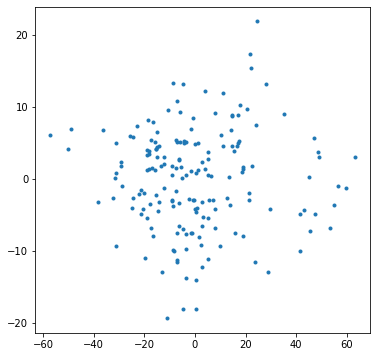

In [38]:
plt.figure(figsize=(6,6))
plt.plot(ts[2,:,42], ts[2,:,41], ".")

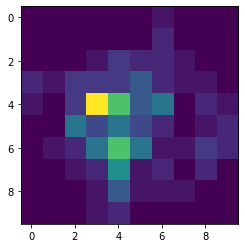

In [39]:
c_xy = np.rot90(np.histogram2d(ts[2,:,42], ts[2,:,41], 10)[0])
plt.imshow(c_xy)

In [40]:
%%time
M = np.zeros((3, n_regions, n_regions))

for k in range(3):
    for i in range(n_regions):
        for j in range(i, n_regions):
            M[k,i,j] = bound(calc_MI(ts[k,:,i], ts[k,:,j]))
            
    M[k] = M[k] + M[k].T
    np.fill_diagonal(M[k], 1)

CPU times: user 9.05 s, sys: 0 ns, total: 9.05 s
Wall time: 9.12 s


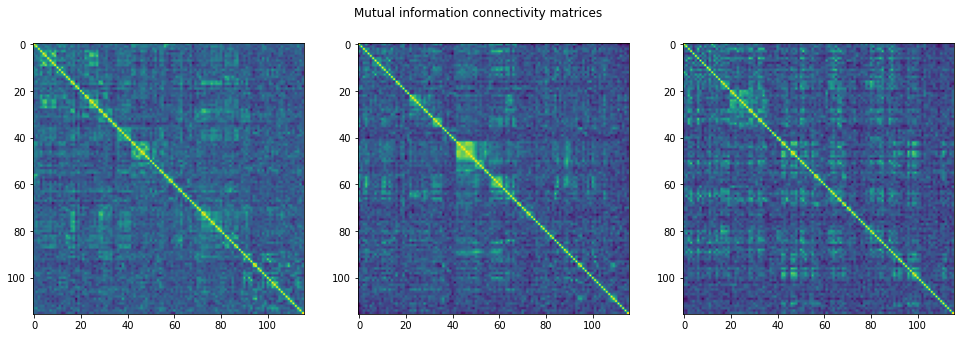

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16.5,5))
plt.suptitle("Mutual information connectivity matrices")
ax1.imshow(M[0])
ax2.imshow(M[1])
ax3.imshow(M[2])
plt.show()



#### Thresholding

In [42]:
R_tresholded = R[0].copy()
np.fill_diagonal(R_tresholded, 0)
R_tresholded[R_tresholded < 0.5] = 0.0
R_tresholded

array([[0.        , 0.76654273, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.76654273, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

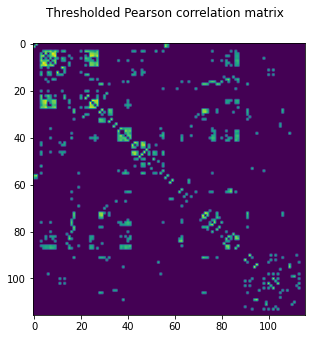

In [43]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
plt.suptitle("Thresholded Pearson correlation matrix")
ax1.imshow(R_tresholded)
plt.show()

## Network visualization

In [44]:
from nilearn import plotting

# get coordinates of brain regions
atlas_aal = nilearn.datasets.fetch_atlas_aal()
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_aal["maps"])

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)



Dataset created in /root/nilearn_data/aal_SPM12



 ...done. (9 seconds, 0 min)
Extracting data from /root/nilearn_data/aal_SPM12/a2fc9a441ebe10d638e4a74b1d3c1dac/aal_for_SPM12.tar.gz..... done.


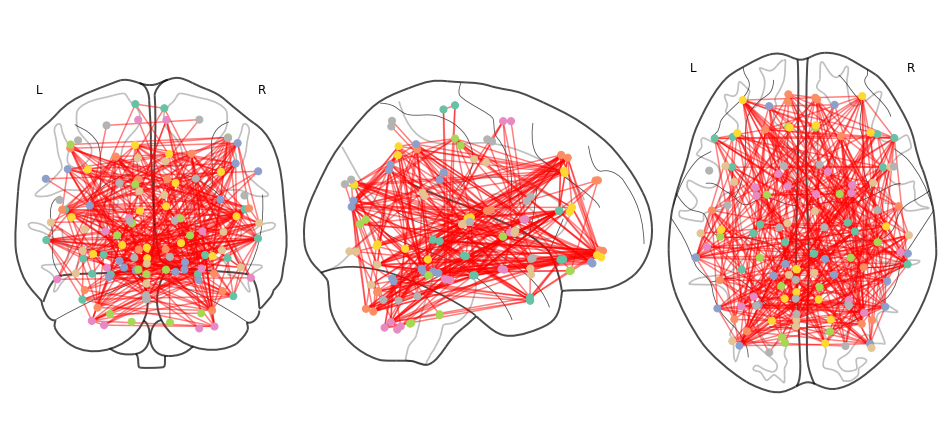

In [45]:
# nilearn graph drawing
fig = plt.figure(figsize=(13,6))
edge_options = {"color": "r", "linewidth": 1.5, "alpha": 0.5}
plotting.plot_connectome(R_tresholded, coordinates, figure=fig, edge_kwargs=edge_options)

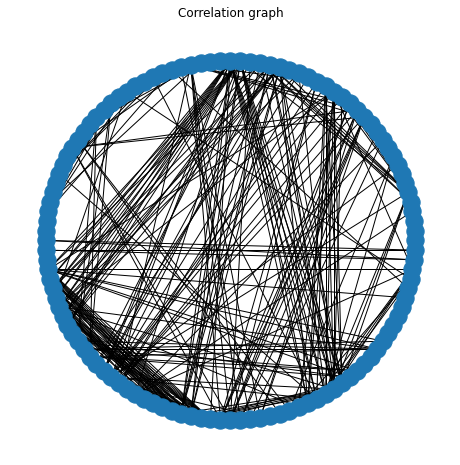

In [46]:
# matplotlib graph drawing
fig, (ax1) = plt.subplots(1, 1, figsize=(8,8))
ax1.set_title("Correlation graph")
nx.draw_shell(nx.from_numpy_array(R_tresholded), ax=ax1)
plt.show()

## Network analysis

### Graph-theoretic

In [47]:
# create graph from connectivity matrix
G_R = nx.from_numpy_array(R_tresholded)

#### Node degree

In [48]:
degree = np.array([degree[1] for degree in nx.degree(G_R)])
degree

array([ 3,  3,  0, 25, 11, 16, 16, 21, 14, 16,  4,  5,  9, 13,  2, 10, 11,
        9,  0,  4,  6,  1, 10,  8, 17, 15, 11, 16, 10, 12,  8,  3,  8,  4,
        2,  3,  8,  9, 11, 15, 21, 13,  7,  9,  5,  1, 13, 10,  1,  5,  1,
        4,  5,  2,  4, 11,  3,  3,  2,  2,  0,  1,  3, 12,  1,  2,  3,  3,
        0,  3,  1,  1, 10,  9,  8,  6, 13,  8,  8,  3,  5,  2, 16, 14,  8,
        3, 20, 19,  0,  0,  4, 11,  4,  4,  2,  3,  1,  0,  6,  2,  7,  3,
        6,  4,  4,  5,  6,  0,  1,  3,  2,  2,  2,  5,  0,  0])

In [49]:
neighbor_degree_avg = np.array(list(nx.average_neighbor_degree(G_R).values()))
neighbor_degree_avg

array([ 3.        ,  3.        ,  0.        , 11.96      , 17.27272727,
       15.6875    , 13.5625    , 14.33333333, 16.21428571, 15.3125    ,
       15.75      ,  9.2       , 13.        , 10.76923077,  2.5       ,
       16.3       , 11.63636364,  8.77777778,  0.        ,  8.75      ,
       14.        ,  3.        , 14.5       , 14.375     , 15.82352941,
       16.46666667, 16.27272727, 14.75      ,  8.5       ,  7.83333333,
        8.        ,  2.66666667,  9.125     ,  9.5       ,  4.        ,
        3.33333333, 13.375     , 14.77777778, 12.        , 11.93333333,
       12.52380952, 13.61538462, 11.42857143, 10.22222222,  8.8       ,
        1.        ,  9.92307692,  9.3       ,  1.        ,  8.2       ,
        2.        ,  9.75      , 13.6       ,  2.5       , 10.        ,
       11.36363636,  3.        ,  3.        ,  2.5       ,  2.5       ,
        0.        ,  4.        , 11.33333333, 11.91666667,  2.        ,
        2.        ,  5.        ,  6.66666667,  0.        ,  6.33

#### Centralities

In [50]:
centrality_betweenness = np.array(list(nx.betweenness_centrality(G_R).values()))
centrality_betweenness

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.62222110e-02,
       1.63030672e-04, 1.46692796e-02, 6.99750251e-02, 6.43522997e-02,
       1.17271571e-03, 1.25717497e-02, 0.00000000e+00, 4.08454878e-03,
       2.52375084e-03, 5.15859631e-02, 0.00000000e+00, 1.24362733e-04,
       5.81341357e-02, 5.53944394e-03, 0.00000000e+00, 4.39325520e-02,
       6.76802242e-04, 0.00000000e+00, 9.49115964e-02, 6.74487797e-02,
       3.06739245e-03, 1.50711343e-03, 5.63236620e-03, 1.71698552e-02,
       2.71066282e-03, 6.57597350e-02, 1.61189058e-01, 8.31426392e-02,
       8.05874271e-03, 1.90380837e-03, 0.00000000e+00, 4.62773133e-02,
       5.31114851e-03, 4.88195030e-04, 4.60521952e-02, 9.07136013e-02,
       3.79574510e-02, 4.40031628e-03, 3.09849927e-03, 5.02402189e-03,
       3.81388253e-05, 0.00000000e+00, 2.80262271e-02, 9.69129980e-03,
       0.00000000e+00, 1.01703534e-04, 0.00000000e+00, 1.57475640e-03,
       5.75714649e-04, 1.44927536e-02, 1.41059454e-02, 5.67125192e-02,
      

In [51]:
centrality_closeness = np.array(list(nx.closeness_centrality(G_R).values()))
centrality_closeness

array([0.02608696, 0.02608696, 0.        , 0.30471152, 0.25768209,
       0.28118993, 0.29571635, 0.29902661, 0.26103951, 0.28118993,
       0.23501211, 0.2309485 , 0.24358398, 0.26713043, 0.14109002,
       0.24211218, 0.27074031, 0.17459506, 0.        , 0.23639861,
       0.24810876, 0.14310559, 0.27729803, 0.27444908, 0.26892326,
       0.26448558, 0.26624296, 0.28118993, 0.17848359, 0.20924055,
       0.23993752, 0.17234222, 0.20186179, 0.19641944, 0.17383759,
       0.20391636, 0.26275125, 0.23850932, 0.25043478, 0.27351239,
       0.29141502, 0.25043478, 0.23501211, 0.23639861, 0.20186179,
       0.00869565, 0.26189258, 0.25043478, 0.00869565, 0.20186179,
       0.13864901, 0.2226087 , 0.24658194, 0.16591952, 0.24358398,
       0.28519263, 0.02608696, 0.02608696, 0.16660942, 0.16660942,
       0.        , 0.18465237, 0.22076895, 0.25603556, 0.15007328,
       0.18254927, 0.20707786, 0.23161598, 0.        , 0.2097883 ,
       0.1868045 , 0.18296605, 0.20707786, 0.17808696, 0.17421

#### Clustering coefficient

In [52]:
clustering_coefficient_local = np.array(list(nx.clustering(G_R).values()))
clustering_coefficient_local

array([1.        , 1.        , 0.        , 0.31666667, 0.90909091,
       0.7       , 0.425     , 0.41904762, 0.79120879, 0.66666667,
       1.        , 0.6       , 0.55555556, 0.38461538, 1.        ,
       0.91111111, 0.34545455, 0.77777778, 0.        , 0.        ,
       0.8       , 0.        , 0.62222222, 0.67857143, 0.66911765,
       0.75238095, 0.61818182, 0.6       , 0.71111111, 0.54545455,
       0.32142857, 0.        , 0.75      , 0.83333333, 1.        ,
       0.33333333, 0.57142857, 0.69444444, 0.4       , 0.40952381,
       0.36190476, 0.55128205, 0.66666667, 0.61111111, 0.9       ,
       0.        , 0.42307692, 0.53333333, 0.        , 0.8       ,
       0.        , 0.83333333, 0.9       , 0.        , 0.33333333,
       0.27272727, 1.        , 1.        , 1.        , 1.        ,
       0.        , 0.        , 1.        , 0.40909091, 0.        ,
       0.        , 0.33333333, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.73333333, 0.83333333, 0.82142

#### Efficiency

In [53]:
nx.local_efficiency(G_R)

0.6090165897387725

In [54]:
nx.global_efficiency(G_R)

0.23643831222916498

## Spectral graph theory

Eigenvalues of
- connectivity matrix
- Laplacian matrix

#### Spectrum

Solve for $\mathbf{\lambda}$ the eigenvalue problem, where $\mathbf{A}$ is the connectivity matrix

$$\mathbf{Av} = \mathbf{\lambda} \mathbf{v}$$

In [55]:
eigenvalues, _ = np.linalg.eigh(R[0])
eigenvalues

array([1.22026561e-15, 5.54955804e-15, 1.74089594e-14, 1.77640386e-12,
       3.81752348e-12, 6.80043599e-12, 1.75349693e-11, 5.15619945e-11,
       1.01372536e-10, 2.41894032e-10, 4.75319337e-10, 6.21096378e-10,
       6.81062826e-10, 1.00121696e-09, 1.26319350e-09, 1.74433432e-09,
       2.25498602e-09, 3.98319155e-09, 4.63823065e-09, 5.28425744e-09,
       6.26189933e-09, 1.06525389e-08, 1.20322837e-08, 1.38846404e-08,
       1.71156171e-08, 2.13154104e-08, 3.31688190e-08, 4.18827976e-08,
       4.44493330e-08, 5.48891689e-08, 6.33010084e-08, 7.77326675e-08,
       9.95553487e-08, 1.05565021e-07, 1.12563306e-07, 1.15049900e-07,
       1.49747730e-07, 1.66038417e-07, 1.83112141e-07, 2.50469304e-07,
       2.92597647e-07, 4.08309536e-07, 4.92038129e-07, 5.72973564e-07,
       6.15420716e-07, 1.22350713e-06, 2.35754011e-06, 1.11624779e-05,
       2.25167386e-05, 4.57788689e-04, 1.41326892e-03, 2.79967052e-03,
       5.02189770e-03, 6.23886343e-03, 9.62929537e-03, 1.24881748e-02,
      

#### Laplacian spectrum

Solve for $\mathbf{\lambda}$ the eigenvalue problem

$$\mathbf{Lv} = \mathbf{\lambda} \mathbf{v},$$

where $\mathbf{L}$ is the Laplacian matrix of the graph given by the connectivity matrix $\mathbf{A}$

$$\mathbf{L} = \mathbf{D} - \mathbf{A}$$

In [58]:
R_tresholded

array([[0.        , 0.76654273, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.76654273, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [59]:
# laplacian matrix L = D - A
# A is contained in variable R_tresholded
A = R_tresholded

# D, your code here
D = np.diag(A.sum(axis=0))

# L, your code here
L = D - A

In [60]:
eigenvalues_laplacian, _ = np.linalg.eigh(L)
eigenvalues_laplacian

array([-1.25272086e-15, -5.10027888e-16, -4.85337123e-16, -4.14358898e-16,
       -2.87403684e-16, -1.84687391e-16,  0.00000000e+00,  0.00000000e+00,
        3.82440124e-32,  1.79761106e-16,  2.87098211e-16,  5.69634304e-16,
        1.77278111e-15,  2.72562350e-15,  3.41984947e-02,  7.14838660e-02,
        1.05342338e-01,  1.38017027e-01,  1.58203077e-01,  1.74903273e-01,
        2.30561602e-01,  2.93206200e-01,  3.11846684e-01,  3.63808408e-01,
        4.08745677e-01,  5.11451537e-01,  5.41531798e-01,  5.57590821e-01,
        6.19921359e-01,  8.05208930e-01,  1.12122570e+00,  1.17702355e+00,
        1.21259739e+00,  1.29244102e+00,  1.60706796e+00,  1.65932744e+00,
        1.67215462e+00,  1.68064344e+00,  1.69544237e+00,  1.73238769e+00,
        1.93369460e+00,  1.96863188e+00,  2.04746845e+00,  2.08508999e+00,
        2.18801904e+00,  2.26477896e+00,  2.32599108e+00,  2.35453461e+00,
        2.39848903e+00,  2.43252166e+00,  2.45271438e+00,  2.47348008e+00,
        2.50171036e+00,  

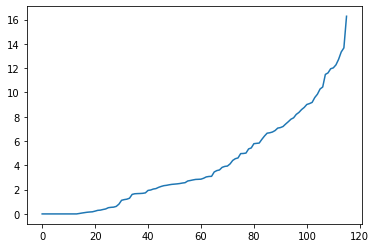

In [61]:
plt.plot(eigenvalues_laplacian)
plt.show()

## Topological

Loops, Betti numbers, persistent homology

In [63]:
pip install ripser

     |████████████████████████████████| 72 kB 296 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 47 kB 4.0 MB/s 
  Created wheel for ripser: filename=ripser-0.6.1-cp37-cp37m-linux_x86_64.whl size=455264 sha256=4ab93967964289065d2b619ab4cc20469189ccc21392c90655722a5e71ed1552
  Stored in directory: /root/.cache/pip/wheels/6b/e3/c8/209a9df47cc9af8c6d2dbee4db558dc129494d3f4fbd670285
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18119 sha256=3da73530c55612354e47ea9484cf485b9e726d3eae266725c87699a3e312b6e9
  Stored in directory: /root/.cache/pip/wheels/d2/9f/a8/67f1b86e47cd17338d3d07939f4660378e65b758c4594f96e3
Successfully built ripser hopcroftkarp


In [64]:
from ripser import ripser
import diagram2vec

In [66]:
# reverse matrix to add higher correlated edges first to the filtration
R_filtered = 1 - np.abs(R[0])

In [67]:
# compute persistence diagram of the network
diagram_R = ripser(R_filtered, distance_matrix=True)["dgms"]
diagram_R

[array([[0.        , 0.04934708],
        [0.        , 0.06462551],
        [0.        , 0.07698476],
        [0.        , 0.08453038],
        [0.        , 0.0915614 ],
        [0.        , 0.10227465],
        [0.        , 0.10564417],
        [0.        , 0.10650206],
        [0.        , 0.11277243],
        [0.        , 0.1154288 ],
        [0.        , 0.11568537],
        [0.        , 0.11744592],
        [0.        , 0.12006845],
        [0.        , 0.12129918],
        [0.        , 0.13377222],
        [0.        , 0.14107943],
        [0.        , 0.14509521],
        [0.        , 0.14803973],
        [0.        , 0.15596533],
        [0.        , 0.15682812],
        [0.        , 0.16129211],
        [0.        , 0.16509286],
        [0.        , 0.1673131 ],
        [0.        , 0.17033628],
        [0.        , 0.17210972],
        [0.        , 0.17242602],
        [0.        , 0.17371853],
        [0.        , 0.1770654 ],
        [0.        , 0.1780248 ],
        [0.   

In [68]:
# vectorize persistent diagram
betti_curve = diagram2vec.persistence_curve(diagram_R)
betti_curve

/usr/local/lib/python3.7/dist-packages/diagram2vec/diagram2vec.py:36: RuntimeWarning: invalid value encountered in multiply
  return x * a + b


array([[[115., 115., 115., 115., 115., 114., 114., 113., 112., 111.,
         110., 107., 103., 101., 100.,  97.,  95.,  92.,  86.,  83.,
          78.,  76.,  73.,  70.,  64.,  59.,  58.,  56.,  54.,  49.,
          47.,  42.,  39.,  39.,  37.,  34.,  30.,  25.,  23.,  21.,
          18.,  15.,  13.,  11.,   9.,   8.,   7.,   6.,   5.,   2.,
           2.,   2.,   2.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
           1.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           1.,   1.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,
           0.,   0.,   0.,   1.,   2.,   2.,   3.,   2.,   4.,   2.,
           2.,   5

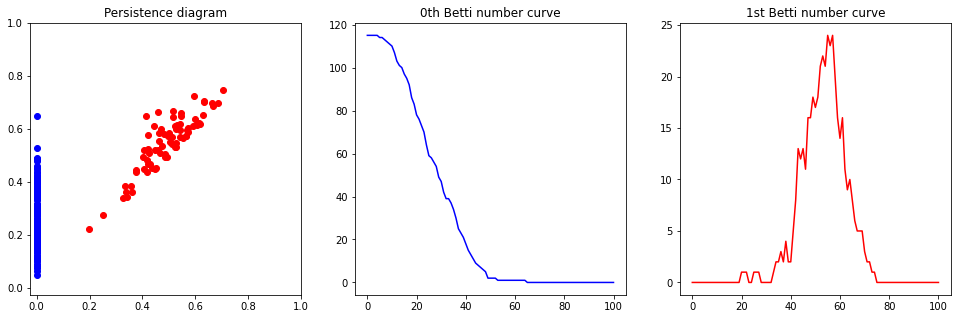

In [69]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16.5,5))
ax1.set_title("Persistence diagram")
ax1.set_xlim(-0.025,1)
ax1.set_ylim(-0.025,1)
ax1.scatter(diagram_R[0][:,0], diagram_R[0][:,1], c="b")
ax1.scatter(diagram_R[1][:,0], diagram_R[1][:,1], c="r")
ax2.set_title("0th Betti number curve")
ax2.plot(betti_curve[0,0], c="b")
ax3.set_title("1st Betti number curve")
ax3.plot(betti_curve[0,1], c="r")
plt.show()

## Machine learning

Use the computed graph, spectral and topological classes features with sklearn classifiers. Try concatenating and/or boosting features of different classes, and stacking/emsembling of classifiers.

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [74]:
# load ABIDE1 data from NYU site
ts = np.load("/content/drive/My Drive/NeuroML/seminar5/data/TS_R_NYU.npy")
y = np.load("/content/drive/My Drive/NeuroML/seminar5/data/y_nyu.npy")

In [75]:
# compute correlation networks
R = ConnectivityMeasure(kind="correlation").fit_transform(ts)
R.shape

(172, 116, 116)

In [76]:
R.shape

(172, 116, 116)

#### Topological features

In [77]:
# topological features
R_filtration = 1 - np.abs(R)

diagrams = []

for i, R_filtered in enumerate(R_filtration):
    diagram = ripser(R_filtered, distance_matrix=True)["dgms"]
    diagrams.append(diagram)

In [78]:
X_topological = diagram2vec.persistence_curve(diagrams, quantity="persistence", m=40)

/usr/local/lib/python3.7/dist-packages/diagram2vec/diagram2vec.py:36: RuntimeWarning: invalid value encountered in multiply
  return x * a + b


In [79]:
X_topological[:,0].shape

(172, 40)

In [80]:
clf = DecisionTreeClassifier(random_state=42, max_depth=5)
cross_val_score(clf, X_topological[:,1], y, cv=10).mean()

0.5830065359477123

#### Graph features

In [81]:
R_thresholded = np.copy(R)
for i in range(R_thresholded.shape[0]):
    np.fill_diagonal(R_thresholded[i], 0)

R_thresholded[R_thresholded < 0.47] = 0.0

In [82]:
# graph features
X_graph = np.zeros((n_patients, n_regions*5))

for i in range(R_thresholded.shape[0]):
    
    G = nx.from_numpy_array(R_thresholded[i])
    
    degree = np.array([degree[1] for degree in nx.degree(G)])
    neighbor_degree_avg = np.array(list(nx.average_neighbor_degree(G).values()))
    centrality_betweenness = np.array(list(nx.betweenness_centrality(G).values()))
    centrality_closeness = np.array(list(nx.closeness_centrality(G).values()))
    clustering_coefficient = np.array(list(nx.clustering(G).values()))
    
    feature_i = np.concatenate((degree, neighbor_degree_avg, centrality_betweenness, centrality_closeness, clustering_coefficient))
    X_graph[i] = feature_i


In [83]:
cross_val_score(clf, X_graph, y, cv=10).mean()

0.5712418300653594

#### Spectral features

In [84]:
# spectral features (eigher spectrum or Laplacian spectrum)
X_spectral = np.zeros((n_patients, n_regions))

for i in range(R_thresholded.shape[0]):
    eigenvalues_i, _ = np.linalg.eigh(R_thresholded[i])
    X_spectral[i] = eigenvalues_i

In [85]:
cross_val_score(clf, X_spectral, y, cv=10).mean()

0.5869281045751635

#### Features concatenation

In [86]:
cross_val_score(clf, np.concatenate((X_graph, X_spectral, X_topological[:,1]), axis=1), y, cv=10).mean()

0.5879084967320262

**Task**

Repeat the feature extraction and machine learning pipeline on mutual information matrices. Note that the estimation of mutual information matrices could be be time-consuming.